# NLP Project

# Imports

In [2]:
import pandas as pd
import numpy as np
from numpy import triu
import nltk
from sklearn.preprocessing import LabelEncoder

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Contractions
import contractions

# Stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

# Tokenization
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Lemmatization 
import spacy
nlp = spacy.load('en_core_web_sm')

# Regex
import re

# DTM 
from sklearn.feature_extraction.text import CountVectorizer

# WordCloud
from wordcloud import WordCloud

# FastText
from gensim.models.fasttext import FastText

# Train / Test split
from sklearn.model_selection import train_test_split, GridSearchCV

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

#Imbalance
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_score




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cristina.flintoaca\AppData\Roaming\nltk_data.
[nltk_data]     ..
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cristina.flintoaca\AppData\Roaming\nltk_data.
[nltk_data]     ..
[nltk_data]   Package punkt is already up-to-date!


## Exploratory Data Analysis

In [3]:
# Gathering the data
url = 'https://github.com/berinde/curs-analiza-datelor-complexe/blob/main/data/input/set_date_examen1.csv?raw=True'
reviews = pd.read_csv(url)
reviews.head(2)

,rest_id,text,rating
0,L772e6l2Yd0DJEyCBxBNng,Everytime I'm in town I hit this place for cur...,5.0
1,L772e6l2Yd0DJEyCBxBNng,I go to State Street Brats every time I am in ...,4.0


In [4]:
# Checking data types
reviews.dtypes

rest_id     object
text        object
rating     float64
dtype: object

In [5]:
# Checking the total no. of reviews
print(len(reviews))

11344


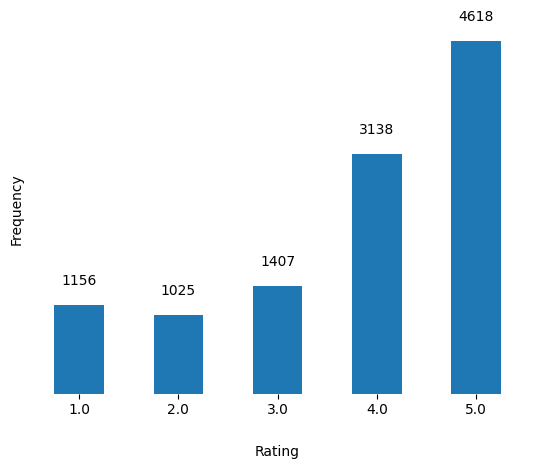

In [6]:
# Checking the no. of reviews based on rating 

fig, ax = plt.subplots()
counts = reviews['rating'].value_counts().sort_index()
counts.plot(kind='bar', ax=ax)

ax.set_title('')
ax.set_xlabel('Rating', labelpad=20)
ax.set_ylabel('Frequency')
sns.despine(bottom=True, left=True)
ax.set_yticks([])
plt.xticks(rotation=360)

# Adding counts
for i, count in enumerate(counts):
    ax.text(i, count + 0.05 * max(counts), str(count), ha='center', va='bottom')

plt.show()

Most reviews tend to be positive (rating > 3.0)

In [7]:
# Converting 'rating' to int
reviews['rating'] = reviews['rating'].astype(int)
print(reviews.dtypes)

rest_id    object
text       object
rating      int32
dtype: object


In [8]:
# Remove the 3-star ratings as they are neutral
print(f'Total no. of reviews: {len(reviews)}')
reviews = reviews[reviews['rating']!=3].reset_index(drop=True)
print(f'Total no. of reviews after removing 3-star ratings: {len(reviews)}')

Total no. of reviews: 11344
Total no. of reviews after removing 3-star ratings: 9937


In [9]:
# new column to quantify the ratings > 3 as positive (1) and those with ratings <3 as negative (0)
reviews['positive'] = np.where(reviews['rating']>3, 1, 0)

In [10]:
# Checking how many reviews are positive and how many are negative
print('Positive reviews:', (len(reviews[reviews['positive']==1])))
print('Negative reviews:', (len(reviews[reviews['positive']==0])))

Positive reviews: 7756
Negative reviews: 2181


In [11]:
# Checking the structure of the dataset
reviews.head()

,rest_id,text,rating,positive
0,L772e6l2Yd0DJEyCBxBNng,Everytime I'm in town I hit this place for cur...,5,1
1,L772e6l2Yd0DJEyCBxBNng,I go to State Street Brats every time I am in ...,4,1
2,L772e6l2Yd0DJEyCBxBNng,State street brats has a dress code that openl...,1,0
3,L772e6l2Yd0DJEyCBxBNng,Sad to have a place like this on campus in Mad...,1,0
4,L772e6l2Yd0DJEyCBxBNng,Place was busy when we got there but the servi...,5,1


## Normalization & text processing of reviews

In [12]:
# Custom function for preprocessing

def preprocesare_text(document):
    # lowercase
    document = document.lower()
    # replace short forms 
    document = contractions.fix(document)
    # regex
    document = re.sub(r'[^\w\s]', ' ', document)
    document = re.sub(r'[^a-z ]', '', document)
    # tokenization
    document = word_tokenize(document)
    # remove common words (stopwords)
    cuv_comune = stopwords.words('english')
    document = [element for element in document if element not in cuv_comune]
    # convert to string
    document = " ".join(document)
    # lemmatization
    document = " ".join([word.lemma_ for word in nlp(document)])

    return document

In [13]:
# new column with the processed reviews
reviews['text_prep'] = reviews['text'].apply(preprocesare_text)
reviews.head(2)

,rest_id,text,rating,positive,text_prep
0,L772e6l2Yd0DJEyCBxBNng,Everytime I'm in town I hit this place for cur...,5,1,everytime town hit place curds beer brat spend...
1,L772e6l2Yd0DJEyCBxBNng,I go to State Street Brats every time I am in ...,4,1,go state street brat every time wisconsin time...


In [14]:
reviews_final = reviews.copy()

In [15]:
reviews_final.head(2)

,rest_id,text,rating,positive,text_prep
0,L772e6l2Yd0DJEyCBxBNng,Everytime I'm in town I hit this place for cur...,5,1,everytime town hit place curds beer brat spend...
1,L772e6l2Yd0DJEyCBxBNng,I go to State Street Brats every time I am in ...,4,1,go state street brat every time wisconsin time...


# I. DTM & Random Forest

### Document Term Matrix

In [16]:
# checking for missing / null values
reviews_final.isnull().sum()

rest_id      0
text         0
rating       0
positive     0
text_prep    0
dtype: int64

In [17]:
# building a vocabulary with the 6k most common words
vec = CountVectorizer(max_features=6000)

# DTM
dtm1 = vec.fit_transform(reviews['text_prep'])
dtm = pd.DataFrame(dtm1.toarray(),
                   columns=vec.get_feature_names_out())

In [18]:
dtm.head(2)

,aa,aback,ability,able,abound,absence,absolute,absolutely,absorb,absurd,...,zen,zero,zest,zesty,ziti,zone,zoo,zoodle,zoodles,zucchini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
dtm.shape

(9937, 6000)

#### WordCloud

(-0.5, 399.5, 199.5, -0.5)

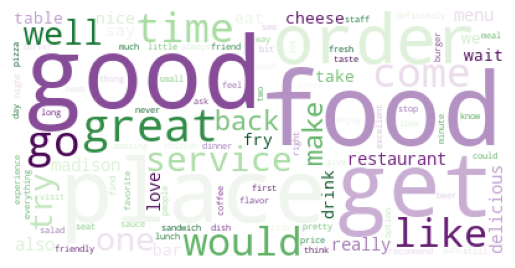

In [20]:
word_cloud = dtm.sum(axis=0)

wordcloud = WordCloud(background_color='white',
                      max_words=100,
                      colormap='PRGn_r')
wordcloud.generate_from_frequencies(word_cloud)
plt.imshow(wordcloud)
plt.axis('off')

### Train Test Split

In [21]:
X_train_dtm, X_test_dtm, y_train_dtm, y_test_dtm = train_test_split(
    dtm, 
    reviews_final['positive'],
    train_size=0.8,
    random_state=42
)

In [22]:
print(len(X_train_dtm), len(X_test_dtm), len(y_train_dtm), len(y_test_dtm))

7949 1988 7949 1988


### Random Forest

In [23]:
# Since I have class imbalance, I'll oversample the minority class (negative reviews) 

oversample = RandomOverSampler(random_state=42)
X_train_os, y_train_os = oversample.fit_resample(X_train_dtm, y_train_dtm)

# RF
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=10, max_depth=5,
                                       n_estimators=100, oob_score=True)

# training RF
classifier_rf.fit(X_train_os, y_train_os)


RandomForestClassifier(max_depth=5, n_jobs=10, oob_score=True, random_state=42)

In [24]:
# I'll use cross-validation to evaluate the model's performance and to check for overfitting or underfitting
scores = cross_val_score(classifier_rf, X_train_os, y_train_os, cv=5, scoring = 'precision')
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", np.mean(scores))


Cross-validation scores: [0.81263617 0.84834835 0.8126346  0.83321033 0.83949704]
Mean cross-validation score: 0.829265297805691


Mean cross-validation score is 0.83 which means that the model is performing well on both the training data (since training and validation sets overlap) and is expected to perform well on similar unseen data.

In [25]:
# predictions
y_test_dtm_pred = classifier_rf.predict(X_test_dtm)
y_test_dtm_pred 

array([0, 1, 1, ..., 0, 1, 1])

In [26]:
# evaluation metrics
print('Classification Report\n',
      classification_report(y_test_dtm, y_test_dtm_pred)
      )

print('Accuracy score for training:', accuracy_score(y_train_os, y_train_os))
print('Accuracy score for test: ', accuracy_score(y_test_dtm, y_test_dtm_pred))

Classification Report
               precision    recall  f1-score   support

           0       0.77      0.82      0.79       437
           1       0.95      0.93      0.94      1551

    accuracy                           0.91      1988
   macro avg       0.86      0.87      0.87      1988
weighted avg       0.91      0.91      0.91      1988

Accuracy score for training: 1.0
Accuracy score for test:  0.9054325955734407


### Interpretation of the classification report

For negative reviews, the accuracy is 0.77, indicating that 77% of the predicted negative reviews were correctly identified. For positive reviews, the accuracy is 0.95, meaning that 95% of the predicted positive reviews were accurately classified.

The training set accuracy is 1.0, demonstrating that the model perfectly classified all the training data, indicating it has learned the training data very well and can accurately classify data similar to it.

The test set accuracy is 0.90, which reflects a slightly lower performance compared to the training set. This reduction in performance could be due to overfitting, potentially caused by the oversampling technique used to address the class imbalance problem.

Overall, the metrics indicate that the model performs exceptionally well for positive reviews but less effectively for negative reviews, as evidenced by the differences between precision and accuracy scores.

### Hyperparameter tuning - Grid Search 

In [27]:

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

params = {
    'max_depth': [5,10,20],
    'min_samples_leaf': [50,100,200],
    'n_estimators': [30,50,100]
}

grid_search = GridSearchCV(estimator=rf,   
                           param_grid=params,  
                           cv = 4,  
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X_train_os, y_train_os)

Fitting 4 folds for each of 27 candidates, totalling 108 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_leaf': [50, 100, 200],
                         'n_estimators': [30, 50, 100]},
             scoring='accuracy', verbose=1)

In [28]:
grid_search.best_score_

0.8901692804513341

In [29]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=20, min_samples_leaf=50, n_jobs=-1,
                       random_state=42)

In [30]:
# predictions
y_test_dtm_pred_grid = rf_best.predict(X_test_dtm)

In [31]:
print('Classification Report pe setul de test\n',
      classification_report(y_test_dtm, y_test_dtm_pred_grid)
      )

Classification Report pe setul de test
               precision    recall  f1-score   support

           0       0.74      0.89      0.81       437
           1       0.97      0.91      0.94      1551

    accuracy                           0.91      1988
   macro avg       0.85      0.90      0.87      1988
weighted avg       0.92      0.91      0.91      1988



### Interpretation

There is s a notable improvement in the F1 score for negative reviews, increasing from 0.79 to 0.89. This enhancement demonstrates that optimizing the model's hyperparameters effectively boosted its overall performance.

# II. FastText & Random Forest

In [32]:
reviews_final_2 = reviews_final.copy()

In [33]:
reviews_final_2.head(2)

,rest_id,text,rating,positive,text_prep
0,L772e6l2Yd0DJEyCBxBNng,Everytime I'm in town I hit this place for cur...,5,1,everytime town hit place curds beer brat spend...
1,L772e6l2Yd0DJEyCBxBNng,I go to State Street Brats every time I am in ...,4,1,go state street brat every time wisconsin time...


In [34]:
# Tokenization
reviews_final_2['text_prep'] = reviews_final_2['text_prep'].astype(str)
corpus = reviews_final_2['text_prep'].apply(word_tokenize).to_list()

In [35]:
# Building the model and the vocabulary from the corpus
ft_model = FastText(min_count=3, vector_size=60, window=10)
ft_model.build_vocab(corpus)
ft_model.train(corpus, total_examples=len(corpus), epochs=5)

(2298861, 2616370)

In [36]:
# Empty lists to store the embeddings and the review labels
ft_review = []
labels = []

for doc in corpus: 
    if doc:  #if the review is not empty, it'll calculate the average of the word vectors for that
        mean = np.mean(ft_model.wv[doc], axis = 0) 
        ft_review.append(mean) # adding the average of the vectors to the empty list
        labels.append(reviews_final_2['positive'][corpus.index(doc)]) #adding the label of the review to the empty list
# Lists to arrays
ft_review = np.array(ft_review)
labels = np.array(labels)

print(ft_review.shape)
print(labels.shape)

(9936, 60)
(9936,)


### Train Test Split FastText

In [37]:
X_train_ft, X_test_ft, y_train_ft, y_test_ft = train_test_split(
    ft_review, 
    labels,
    train_size=0.8,
    random_state=42
)

In [38]:
# Since I have class imbalance, I'll oversample the minority class (negative reviews)

oversample = RandomOverSampler(random_state=42)
X_train_ft_os, y_train_ft_os = oversample.fit_resample(X_train_ft, y_train_ft)

# PF
classifier_rf2 = RandomForestClassifier(random_state=42, n_jobs=10, max_depth=5,
                                       n_estimators=100, oob_score=True)

# Training RF
classifier_rf2.fit(X_train_ft_os, y_train_ft_os)

RandomForestClassifier(max_depth=5, n_jobs=10, oob_score=True, random_state=42)

In [39]:
 # I'll use cross-validation to evaluate the model's performance and to check for overfitting or underfitting

scores_2 = cross_val_score(classifier_rf2, X_train_ft_os, y_train_ft_os, cv=5)
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", np.mean(scores))

# Mean cross-validation score e 0.85 ceea ce inseamna modelul / clasificatorul 
# se comporta destul de bine pe training data 

Cross-validation scores: [0.81263617 0.84834835 0.8126346  0.83321033 0.83949704]
Mean cross-validation score: 0.829265297805691


In [40]:
# Predictions
y_test_ft_pred = classifier_rf2.predict(X_test_ft)

In [41]:
print('Classification Report\n',
      classification_report(y_test_ft, y_test_ft_pred))

print('Accuracy score for training:', accuracy_score(y_train_ft_os, y_train_ft_os))
print('Accuracy score for test: ', accuracy_score(y_test_ft, y_test_ft_pred))

Classification Report
               precision    recall  f1-score   support

           0       0.62      0.83      0.71       427
           1       0.95      0.86      0.90      1561

    accuracy                           0.85      1988
   macro avg       0.78      0.85      0.81      1988
weighted avg       0.88      0.85      0.86      1988

Accuracy score for training: 1.0
Accuracy score for test:  0.8536217303822937


### Interpretation and comparison of classification reports (DTM - Random Forest vs. Fast-text Random Forest)

For negative reviews, the accuracy is 0.62, indicating that 62% of the reviews predicted as negative were correctly classified. In contrast, for positive reviews, the accuracy is 0.95, meaning that 95% of the predicted positive reviews were accurate. Overall, the DTM-Random Forest model outperforms the FastText-Random Forest model, particularly in handling negative reviews (77% vs. 62%).

The model achieved an accuracy of 1.0 on the training set, indicating that it perfectly classified all training data and learned it thoroughly. However, the accuracy on the test set is 0.85, which suggests a potential issue of overfitting. Despite this, the overall performance of the model remains quite good. This result aligns with the performance of the DTM-Random Forest model.

The metrics indicate that both models excel in classifying positive reviews but are less effective with negative reviews, as evidenced by the differences between precision and accuracy scores. However, the DTM-Random Forest model demonstrates superior performance compared to the FastText-Random Forest model, as reflected by the f1-scores.

### Hyperparameter tuning - Grid Search 

In [42]:
rf2  = RandomForestClassifier(random_state=42, n_jobs=-1)

params = {
    'max_depth': [5,10,20],
    'min_samples_leaf': [50,100,200],
    'n_estimators': [30,50,100]
}

# Grid Search
grid_search = GridSearchCV(estimator=rf2,   
                           param_grid=params,  
                           cv = 4,  
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X_train_ft_os, y_train_ft_os)

Fitting 4 folds for each of 27 candidates, totalling 108 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_leaf': [50, 100, 200],
                         'n_estimators': [30, 50, 100]},
             scoring='accuracy', verbose=1)

In [43]:
grid_search.best_score_

0.8628730859097904

In [44]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=20, min_samples_leaf=50, n_estimators=30,
                       n_jobs=-1, random_state=42)

In [45]:
# predictions
y_test_ft_pred_grid = rf_best.predict(X_test_ft)

In [46]:
print('Classification Report pe setul de test\n',
      classification_report(y_test_ft, y_test_ft_pred_grid))

Classification Report pe setul de test
               precision    recall  f1-score   support

           0       0.64      0.83      0.72       427
           1       0.95      0.87      0.91      1561

    accuracy                           0.86      1988
   macro avg       0.79      0.85      0.82      1988
weighted avg       0.88      0.86      0.87      1988



### Interpretation
The metrics show improvement, particularly for negative reviews, indicating that optimizing the model's hyperparameters effectively enhanced its performance. Notably, the DTM-Random Forest model with hyperparameter tuning outperforms the FastText-Random Forest model with hyperparameter tuning, as the latter exhibits a significant decrease in F1 score, precision, and recall.






### Conclusions

Considering the metrics of all models, the DTM-Random Forest model with hyperparameter tuning stands out as the best performer in predicting positive and negative reviews. This model excels in precision, recall, F1 scores, and accuracy compared to the other models. Despite the apparent overfitting due to the class imbalance solution, its overall performance remains superior.